In [1]:
import numpy as np # linear algebra
from numpy import newaxis
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
 
from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D,Conv2D
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, TimeDistributed, MaxPooling2D
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
from keras.utils import to_categorical, normalize
import talib as ta
import psycopg2
from configparser import ConfigParser
plt.style.use('fivethirtyeight')

pd.options.display.max_columns = 50  # None -> No Restrictions
pd.options.display.max_rows = 200    # None -> Be careful with this 
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

print ('import completed')

Using TensorFlow backend.
C:\Users\kriz_\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kriz_\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kriz_\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kriz_\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

import completed


In [137]:
# Enter in how much steps we will enroll the network.
# RNN/LSTM/GRU can be taught patterns over times series as big as the number of times you enrol them, and no bigger (fundamental limitation). 
# So by design these networks are deep/long to catch recurrent patterns.
#timesteps per samples
Enrol_window = 5

print ('enrol window set to',Enrol_window )

enrol window set to 5


In [130]:
# Support functions
scaler = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))
std_scaler = StandardScaler()


# for multivariate, nth timesteps output is used for n timesteps input so first output before nth is not used (Multiple Input Series)
def split_multi(sequences, n_steps):
    sequences = sequences.to_numpy()
#     print(sequences)
    
    X, y = [], []
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        X.append(sequences[i:end_ix, :-1])
        y.append(sequences[end_ix, -1])
        
    return np.array(X), np.array(y)

def split_multi_output(sequences, n_steps_in, n_steps_out):
    sequences = sequences.to_numpy()
#     print(sequences)
    
    X, y = [], []
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        X.append(sequences[i:end_ix, :-1])
        y.append(sequences[end_ix:out_end_ix, -1])
        
    return np.array(X), np.array(y)
                           
#for univariate(1 feature)
def split_uni(sequences, n_steps,normalise_window):
    sequence_length = n_steps + 1
    result = []
    for index in range(len(sequences) - sequence_length):
        result.append(sequences[index: index + sequence_length])
    
    if normalise_window:
        #result = sc.fit_transform(result)
        result = normalise_windows(result)

    return np.array(result)
                           
def load_data(datasetname, column, seq_len, normalise_window, n_outputs):
    # A support function to help prepare datasets for an RNN/LSTM/GRU
    data = datasetname.loc[:,column]
    
    row = round(0.6 * data.shape[0])
    
    if normalise_window:
#         data = std_scaler.fit_transform(data)
#         data = scaler.fit_transform(data)
        data_x = data.iloc[:,:-1]
        min_value, max_value = data_x.min().min(), data_x.max().max()
        data_x = (data_x - min_value) / (max_value - min_value)
        data.iloc[:,:-1] = data_x
        
        data_y = data.iloc[:,-1]
        min_value, max_value = data_y.min(), data_y.max()
        data_y = (data_y - min_value) / (max_value - min_value)
        data.iloc[:,-1] = data_y
        
    
    data = pd.DataFrame(data,columns = column)
    
    data_train = data[:int(row)]
    data_test = data[int(row):]
    
#     if normalise_window:
#         data_train = std_scaler.fit_transform(data_train)
#         data_test = std_scaler.transform(data_test)
        
#         data_train = scaler.fit_transform(data_train)
#         data_test = scaler.transform(data_test)
#           data_train = scaler.fit_transform(data_train)
#         data_test = scaler.transform(data_test)
# scaler_y = MinMaxScaler(feature_range=(0,1))
        
    
#     data = pd.DataFrame(data,columns = column)
#     data_test = pd.DataFrame(data_test,columns = data.columns)
    
    print(data.describe())
    
    x_train, y_train = split_multi_output(data_train, seq_len, n_outputs)
    x_test, y_test = split_multi_output(data_test, seq_len, n_outputs)
    
#     y_train =to_categorical(y_train)
#     y_test =to_categorical(y_test)
#     print(y_train)
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    # A support function to normalize a dataset
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of <prediction_len> steps before shifting prediction run forward by <prediction_len> steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white', figsize = (12,12)) 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.plot(predicted_data, label='Prediction', color ='red') 
    plt.legend() 
    plt.show() 

def plot_result(predicted_data): 
    fig = plt.figure(facecolor='white') 
    ax = fig.add_subplot(111) 
    plt.plot(predicted_data, label='Prediction') 
    plt.legend() 
    plt.show() 
    
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

print ('Support functions defined')

Support functions defined


In [4]:
lq45 = ['ACES','ADRO','AKRA','ANTM','ASII',
            'BBCA','BBNI','BBRI','BBTN','BMRI',
            'BSDE','BTPS','CPIN','CTRA','ERAA',
            'EXCL','GGRM','HMSP','ICBP','INCO',
            'INDF','INKP','INTP','ITMG','JPFA',
            'JSMR','KLBF','MDKA','MIKA','MNCN',
            'PGAS','PTBA','PTPP','PWON','SCMA',
            'SMGR','SMRA','SRIL','TBIG','TKIM',
            'TLKM','TOWR','UNTR','UNVR','WIKA'
       ]

kompas100 = 'AALI,ACES,ADHI,ADRO,AKRA,ANTM,APLN,ASII,ASSA,BBCA,BBKP,BBNI,BBRI,BBTN,BDMN,BEST,BJBR,BJTM,BMRI,BMTR,BNLI,BRIS,BRPT,BSDE,BTPS,BULL,CLEO,CPIN,CTRA,DMAS,ELSA,ERAA,EXCL,GGRM,GIAA,HKMU,HMSP,HOKI,ICBP,INAF,INCO,INDF,INDY,INKP,INTP,ISAT,ITMG,JPFA,JRPT,JSMR,KAEF,KBLI,KINO,KLBF,LINK,LPKR,LPPF,LSIP,MAIN,MAPI,MDKA,MEDC,MIKA,MNCN,MTDL,MYOR,PGAS,PNBN,PNLF,PSAB,PTBA,PTPP,PWON,RALS,SCMA,SIDO,SILO,SIMP,SMBR,SMGR,SMRA,SMSM,SPTO,SRIL,SSIA,SSMS,TBIG,TINS,TKIM,TLKM,TOWR,TPIA,UNTR,UNVR,WEGE,WIKA,WOOD,WSBP,WSKT,WTON'
kompas100 = kompas100.split(',')

def config(filename="D:\python\database.ini", section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)

    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))

    return db

def get_stocks_data(date):
    """ query tickers from the idxstocks table """
    conn = None
    stocks_df = None
    try:
        params = config()
        conn = psycopg2.connect(**params)
        sql="SELECT date, stock, close, volume, foreign_buy, foreign_sell FROM idxstocks WHERE date >= %s::Date"
        stocks_df = pd.read_sql(sql,conn, None, params=[date])
        print("The number of dates: ", len(stocks_df.index.unique()))

    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
    return stocks_df

def get_broksum_data(date):
    conn = None
    broksum_df = None
    try:
        params = config()
        conn = psycopg2.connect(**params)
        sql="SELECT * FROM brokersummary WHERE date >= %s::Date"
        broksum_df = pd.read_sql(sql,conn, None, params=[date])
        print("The number of dates: ", len(broksum_df.index.unique()))

    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
    return broksum_df


today = '2020-12-18'
date = "2020-01-01"
all_stocks_df = get_stocks_data(date)
all_stocks_df['date'] = pd.to_datetime(all_stocks_df['date'])
all_stocks_df = all_stocks_df.set_index('date').sort_index()
broksum_df = get_broksum_data(date)
broksum_df['date'] = pd.to_datetime(broksum_df['date'])
broksum_df = broksum_df.set_index('date').sort_index()

The number of dates:  172315
The number of dates:  4834444


In [68]:
my_stock = ['MDKA','TINS','JPFA','PZZA','ASII','NATO']
check =['ANTM']
selected_stocks = check

In [105]:

# print(broksum_df)
broksum_selected = broksum_df[broksum_df.stock.isin(selected_stocks)]
broksum_selected 
broksum_selected['buy'] = broksum_selected['buy'].replace({True: 1, False: 0})
broksum_selected['volume'] = broksum_selected['volume']*100

# print(broksum_selected)
broksum_pivot = pd.pivot_table(broksum_selected, index=[broksum_selected.index,'stock'], columns=['buy','broker']).fillna(0)
# print(broksum_pivot.columns)
# print(broksum_selected[broksum_selected.index=='2020-01-02'].sort_values(by=['broker','buy']))
# print(broksum_pivot['volume'])
# print(broksum_pivot.columns)
diff = broksum_pivot[('volume',1)]-broksum_pivot[('volume',0)]
diff.columns = pd.MultiIndex.from_tuples([('volume', 'net', col) for col in diff.columns])
# print(diff)
broksum_pivot = pd.concat([broksum_pivot, diff],axis =1)
broksum_pivot = broksum_pivot.reset_index(level='stock')
# print(broksum_pivot)
# print(broksum_pivot.columns)

broksum_vol_net = broksum_pivot[('volume','net')]
#     print(broksum_vol_net.columns.values)
broksum_vol_cumsum = broksum_vol_net.cumsum()
# print(broksum_vol_cumsum.columns)

stock_df_selected = all_stocks_df[all_stocks_df.stock.isin(selected_stocks)]
stock_df = stock_df_selected.iloc[:len(broksum_vol_cumsum)]
broksum_vol_cumsum['label'] = stock_df['close']
broksum_vol_cumsum = broksum_vol_cumsum.dropna(1)

print(broksum_vol_cumsum)

C:\Users\kriz_\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\kriz_\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


broker             AD         AF         AG         AH         AI         AK  \
date                                                                           
2020-01-02  8.000e+03  0.000e+00 -3.200e+04 -5.400e+04  2.000e+05  3.469e+06   
2020-01-03 -5.140e+04  0.000e+00 -8.949e+05 -5.400e+04 -3.487e+06  7.885e+06   
2020-01-06 -3.682e+05  0.000e+00 -1.744e+06 -2.637e+05 -4.227e+06  9.524e+06   
2020-01-07 -1.708e+05  0.000e+00 -1.819e+06 -2.637e+05 -3.926e+06  8.087e+06   
2020-01-08 -5.461e+05 -1.700e+04 -2.189e+06 -2.637e+05 -6.800e+06  1.252e+07   
...               ...        ...        ...        ...        ...        ...   
2021-01-04  2.461e+06  1.921e+06 -4.490e+06  1.144e+06 -9.859e+06 -6.667e+07   
2021-01-05  2.461e+06  1.752e+06 -3.731e+06  7.937e+05 -5.708e+05 -6.398e+07   
2021-01-06  2.461e+06  2.791e+06 -3.652e+06  1.253e+06 -1.434e+06 -7.064e+07   
2021-01-07  2.461e+06  3.187e+05 -3.458e+06  1.296e+06 -4.443e+05 -7.131e+07   
2021-01-08  2.461e+06  1.466e+06 -3.439e

C:\Users\kriz_\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2878: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [ ]:
broksum_selected = broksum_df[broksum_df.stock.isin(selected_stocks)]
broksum_selected['buy'] = broksum_selected['buy'].replace({True: 1, False: 0})
broksum_selected['volume'] = broksum_selected['volume']*100

# print(broksum_selected)
broksum_pivot = pd.pivot_table(broksum_selected, index=[broksum_selected.index], columns=['buy','broker']).fillna(0)
diff = broksum_pivot[('volume',1)]-broksum_pivot[('volume',0)]
diff.columns = pd.MultiIndex.from_tuples([('volume', 'net', col) for col in diff.columns])
# print(diff)
broksum_pivot = pd.concat([broksum_pivot, diff],axis =1)
# print(broksum_pivot)
stock_df_selected = all_stocks_df[all_stocks_df.stock.isin(selected_stocks)]
# print(stock_df_selected)

stock_df_selected = pd.concat([stock_df_selected, broksum_pivot],axis =1)
# print(stock_df_selected.columns)

# print(stock_df_selected)
stock_df_selected['date'] = stock_df_selected.index
# stock_df_selected['dayofweek'] = stock_df_selected['date'].dt.dayofweek
# stock_df_selected['quarter'] = stock_df_selected['date'].dt.quarter
# stock_df_selected['month'] = stock_df_selected['date'].dt.month
# # stock_df_selected['year'] = stock_df_selected['date'].dt.year
# stock_df_selected['dayofyear'] = stock_df_selected['date'].dt.dayofyear
stock_df_selected['dayofmonth'] = stock_df_selected['date'].dt.day
# stock_df_selected['weekofyear'] = stock_df_selected['date'].dt.weekofyear

# stock_df_selected['EMA5'] = ta.EMA(stock_df_selected['close'], timeperiod=5)
# stock_df_selected['EMA10'] = ta.EMA(stock_df_selected['close'], timeperiod=10)
# stock_df_selected['EMA15'] = ta.EMA(stock_df_selected['close'], timeperiod=15)
# stock_df_selected['EMA20'] = ta.EMA(stock_df_selected['close'], timeperiod=10)
# stock_df_selected['EMA30'] = ta.EMA(stock_df_selected['close'], timeperiod=30)
# stock_df_selected['EMA40'] = ta.EMA(stock_df_selected['close'], timeperiod=40)
# stock_df_selected['EMA50'] = ta.EMA(stock_df_selected['close'], timeperiod=50)

# stock_df_selected['EMA60'] = ta.EMA(stock_df_selected['close'], timeperiod=60)
# stock_df_selected['EMA70'] = ta.EMA(stock_df_selected['close'], timeperiod=70)
# stock_df_selected['EMA80'] = ta.EMA(stock_df_selected['close'], timeperiod=80)
# stock_df_selected['EMA90'] = ta.EMA(stock_df_selected['close'], timeperiod=90)

# stock_df_selected['EMA100'] = ta.EMA(stock_df_selected['close'], timeperiod=100)
# stock_df_selected['EMA150'] = ta.EMA(stock_df_selected['close'], timeperiod=150)
# stock_df_selected['EMA200'] = ta.EMA(stock_df_selected['close'], timeperiod=200)

stock_df_selected['upperBB'], stock_df_selected['middleBB'], stock_df_selected['lowerBB'] = ta.BBANDS(stock_df_selected['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

stock_df_selected['SAR'] = ta.SAR(stock_df_selected['high'], stock_df_selected['low'], acceleration=0.02, maximum=0.2)

stock_df_selected['RSI'] = ta.RSI(stock_df_selected['close'], timeperiod=14)

# stock_df_selected['aboveEMA5'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA5'], 1, -1)
# stock_df_selected['aboveEMA10'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA10'], 1, -1)
# stock_df_selected['aboveEMA15'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA15'], 1, -1)
# stock_df_selected['aboveEMA20'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA20'], 1, -1)
# stock_df_selected['aboveEMA30'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA30'], 1, -1)
# stock_df_selected['aboveEMA40'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA40'], 1, -1)

# stock_df_selected['aboveEMA50'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA50'], 1, -1)
# stock_df_selected['aboveEMA60'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA60'], 1, -1)
# stock_df_selected['aboveEMA70'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA70'], 1, -1)
# stock_df_selected['aboveEMA80'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA80'], 1, -1)
# stock_df_selected['aboveEMA90'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA90'], 1, -1)

# stock_df_selected['aboveEMA100'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA100'], 1, -1)
# stock_df_selected['aboveEMA150'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA150'], 1, -1)
# stock_df_selected['aboveEMA200'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA200'], 1, -1)

# stock_df_selected['aboveUpperBB'] = np.where(stock_df_selected['close'] > stock_df_selected['upperBB'], 1, -1)
# stock_df_selected['belowlowerBB'] = np.where(stock_df_selected['close'] < stock_df_selected['lowerBB'], 1, -1)

# stock_df_selected['aboveSAR'] = np.where(stock_df_selected['close'] > stock_df_selected['SAR'], 1, -1)

# stock_df_selected['oversoldRSI'] = np.where(stock_df_selected['RSI'] < 30, 1, -1)
# stock_df_selected['overboughtRSI'] = np.where(stock_df_selected['RSI'] > 70, 1, -1)


stock_df_selected['nbsa'] = stock_df_selected['foreign_buy']-stock_df_selected['foreign_sell']
stock_df_selected['nbsa_cumsum'] = stock_df_selected['nbsa'].cumsum()
stock_df_selected['fn_vol'] = (stock_df_selected['foreign_buy']+stock_df_selected['foreign_sell'])/2
# stock_df_selected['fn_buy_part'] = stock_df_selected['foreign_buy']/(2*stock_df_selected['fn_vol'])
# stock_df_selected['fn_sell_part'] = stock_df_selected['foreign_sell']/(2*stock_df_selected['fn_vol'])
# stock_df_selected['log_nbsa'] = np.log(stock_df_selected['foreign_buy'])-np.log(stock_df_selected['foreign_sell'])

stock_df_selected['fn_part'] = stock_df_selected['fn_vol']/stock_df_selected['volume']
stock_df_selected['fn_net_str'] = abs(stock_df_selected['nbsa'])/(stock_df_selected['fn_vol']*2)

# stock_df_selected.hist(figsize=(20,20))

stock_df_selected['log_prev'] = np.log(stock_df_selected.prev)
stock_df_selected['log_low'] = np.log(stock_df_selected.low)
stock_df_selected['log_high'] = np.log(stock_df_selected.high)
# stock_df_selected['close'] = np.log(stock_df_selected.close)
stock_df_selected['log_close'] = np.log(stock_df_selected.close)
# stock_df_selected['volume'] = np.log(stock_df_selected.volume+1)
# stock_df_selected['value'] = np.log(stock_df_selected.value+1)
# stock_df_selected['freq'] = np.log(stock_df_selected.freq)
# stock_df_selected['offer'] = stock_df_selected.offer
# stock_df_selected['bid'] = np.log(stock_df_selected.bid+1)
# stock_df_selected['offer_volume'] = np.log(stock_df_selected.offer_volume+1)
# stock_df_selected['bid_volume'] = np.log(stock_df_selected.bid_volume+1)
# stock_df_selected['nbsa_cumsum'] = stock_df_selected.nbsa_cumsum-min(stock_df_selected.nbsa_cumsum)
# stock_df_selected[['nbsa_cumsum']] = scaler.fit_transform(stock_df_selected[['nbsa_cumsum']])
# stock_df_selected['fn_vol'] = np.log(stock_df_selected.fn_vol+1)
# stock_df_selected['fn_net_str'] = np.log(stock_df_selected.fn_net_str+1)

stock_df_selected['log_ret_close'] = stock_df_selected.log_close-stock_df_selected.log_close.shift(1)
stock_df_selected['log_ret_high'] = stock_df_selected.log_high-stock_df_selected.log_high.shift(1)
stock_df_selected['log_ret_low'] = stock_df_selected.log_low-stock_df_selected.log_low.shift(1)
stock_df_selected['log_ret_prev'] = stock_df_selected.log_prev-stock_df_selected.log_prev.shift(1)

stock_df_selected.loc[stock_df_selected['log_ret_close'] == 0, 'out'] = 0 
stock_df_selected.loc[stock_df_selected['log_ret_close'] > 0, 'out'] = 1
stock_df_selected.loc[stock_df_selected['log_ret_close'] < 0, 'out'] = -1

stock_df_selected['label'] = stock_df_selected['close']
# stock_df_selected['label'] = to_categorical(stock_df_selected['label'])

stock_df_selected = stock_df_selected.drop(columns=['date','stock', 'high','low', 'prev', 'close', 'log_low',
                                                     'offer', 'offer_volume', 'bid', 'bid_volume',
                                                    'log_high','change','weight_for_index','listed_shares','tradable_shares',
                                                    'stock_name','remarks','index_individual','non_regular_volume',
                                                    'non_regular_value', 'non_regular_freq','open_price','first_trade'])

stock_df_selected = stock_df_selected.fillna(0)

# stock_df_selected = pd.DataFrame(normalize(stock_df_selected, axis=-1, order=2))



stock_df_selected.hist(figsize=(20,20))

# print(stock_df_selected.nbsa_cumsum)
# stock_df_selected.describe()
display(stock_df_selected)

In [34]:
print(stock_df_selected.columns)

Index([        'volume',          'value',           'freq',   'foreign_sell',
          'foreign_buy', ('avg', 0, 'AD'), ('avg', 0, 'AF'), ('avg', 0, 'AG'),
       ('avg', 0, 'AH'), ('avg', 0, 'AI'),
       ...
              'fn_part',     'fn_net_str',       'log_prev',      'log_close',
        'log_ret_close',   'log_ret_high',    'log_ret_low',   'log_ret_prev',
                  'out',          'label'],
      dtype='object', length=752)


In [138]:
# Prepare the dataset, note that the stock price data will be normalized between 0 and 1
# A label is the thing we're predicting
# A feature is an input variable

# print(stock_df_selected['log_ret'])
n_outputs=1
# feature_train, label_train, feature_test, label_test = load_data(stock_df_selected, stock_df_selected.columns, Enrol_window, True, n_outputs)
feature_train, label_train, feature_test, label_test = load_data(broksum_vol_cumsum, broksum_vol_cumsum.columns, Enrol_window, True, n_outputs)
print(broksum_vol_cumsum.shape)

# print(feature_test)
print(feature_train)
print(label_train)
# feature_train.describe()
# stock_df_selected["log_ret"][:'2019'].plot(figsize=(16,4),legend=True)
# stock_df_selected["log_ret"]['2020':].plot(figsize=(16,4),legend=True) # 10% is used for thraining data which is approx 2017 data
# plt.legend(['Training set (First 90%, approx before 2017)','Test set (Last 10%, approax 2017 and beyond)'])
# plt.title('stock price')
# plt.show()

broker       AD       AF       AG       AH       AI       AK       AN  \
count   247.000  247.000  247.000  247.000  247.000  247.000  247.000   
mean      0.526    0.524    0.519    0.522    0.516    0.377    0.524   
std       0.002    0.005    0.005    0.002    0.026    0.098    0.001   
min       0.521    0.520    0.506    0.518    0.433    0.281    0.522   
25%       0.527    0.521    0.516    0.521    0.498    0.305    0.523   
50%       0.527    0.522    0.520    0.522    0.516    0.326    0.524   
75%       0.527    0.526    0.523    0.524    0.540    0.444    0.524   
max       0.527    0.542    0.527    0.527    0.564    0.565    0.528   

broker       AO         AP       AR       AT       AZ       BF       BK  \
count   247.000  2.470e+02  247.000  247.000  247.000  247.000  247.000   
mean      0.518  5.220e-01    0.522    0.526    0.602    0.518    0.530   
std       0.008  3.964e-04    0.006    0.008    0.082    0.002    0.029   
min       0.502  5.216e-01    0.509    0.5

In [ ]:
print(stock_df_selected.tail(11))

In [ ]:
from keras.models import load_model
 
# load model
model = load_model('model.h5')
# summarize model.
model.summary()

In [139]:
# Note: replace LSTM with GRU or SimpleRNN if you want to try those

model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(feature_train.shape[1],feature_train.shape[2]))) #n_steps,n_features
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(n_outputs, activation = "linear"))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

print ('model compiled')

print (model.summary())

model compiled
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 5, 100)            82000     
_________________________________________________________________
dropout_41 (Dropout)         (None, 5, 100)            0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_42 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 101       
Total params: 162,501
Trainable params: 162,501
Non-trainable params: 0
_________________________________________________________________
None


Train on 143 samples, validate on 94 samples
Epoch 1/50
143/143 [==============================] - 2s 12ms/step - loss: 0.0206 - accuracy: 0.0070 - val_loss: 0.0415 - val_accuracy: 0.0000e+00
Epoch 2/50
143/143 [==============================] - 0s 446us/step - loss: 0.0748 - accuracy: 0.0070 - val_loss: 0.0579 - val_accuracy: 0.0000e+00
Epoch 3/50
143/143 [==============================] - 0s 472us/step - loss: 0.0186 - accuracy: 0.0070 - val_loss: 0.1287 - val_accuracy: 0.0000e+00
Epoch 4/50
143/143 [==============================] - 0s 483us/step - loss: 0.0090 - accuracy: 0.0070 - val_loss: 0.1868 - val_accuracy: 0.0000e+00
Epoch 5/50
143/143 [==============================] - 0s 546us/step - loss: 0.0292 - accuracy: 0.0070 - val_loss: 0.1816 - val_accuracy: 0.0000e+00
Epoch 6/50
143/143 [==============================] - 0s 437us/step - loss: 0.0251 - accuracy: 0.0070 - val_loss: 0.1448 - val_accuracy: 0.0000e+00
Epoch 7/50
143/143 [==============================] - 0s 483us/step 

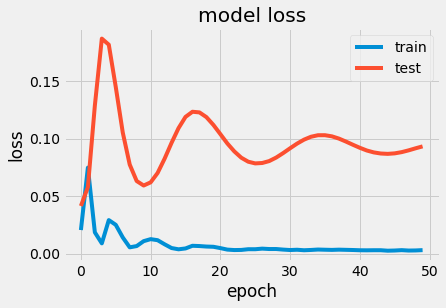

In [140]:
#Train the model
history = model.fit(feature_train, label_train, batch_size=512, epochs=50, validation_data = (feature_test, label_test))
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [104]:
scores = model.evaluate(feature_test, label_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# save model and architecture to single file
model.save("model.h5")
print("Saved model to disk")

accuracy: 1.17%
Saved model to disk


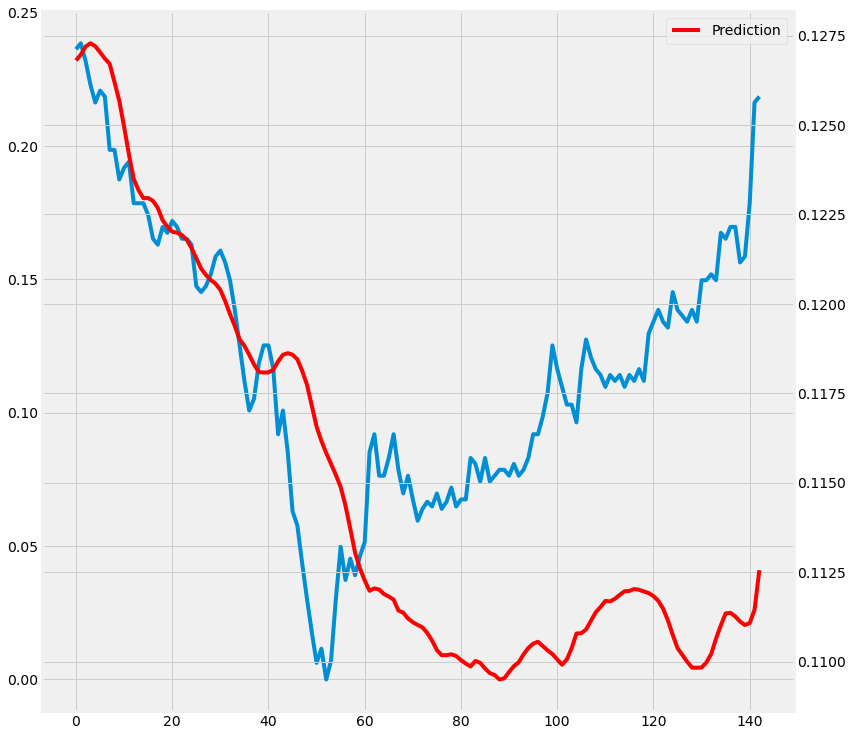

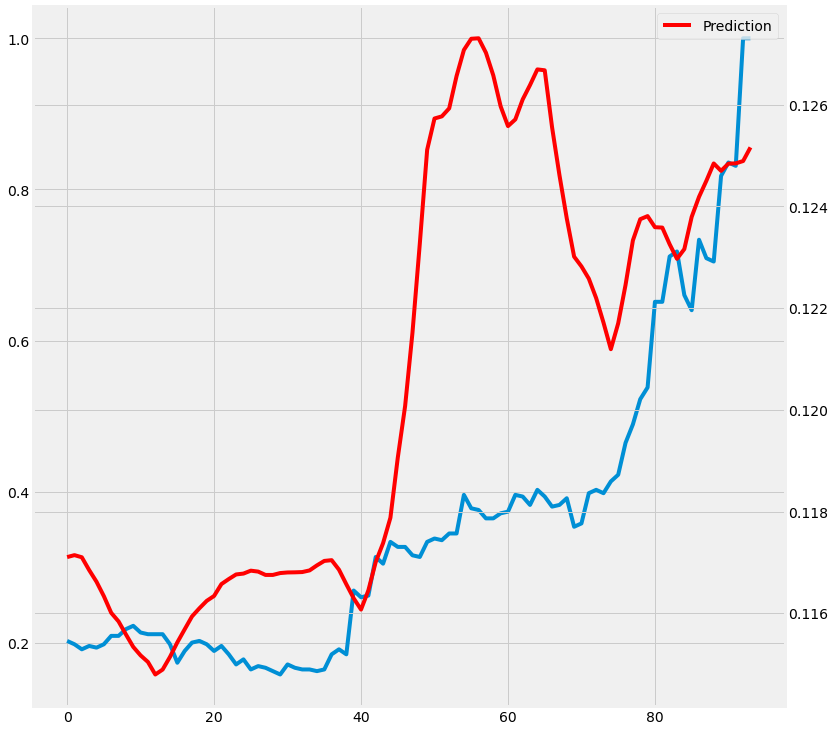

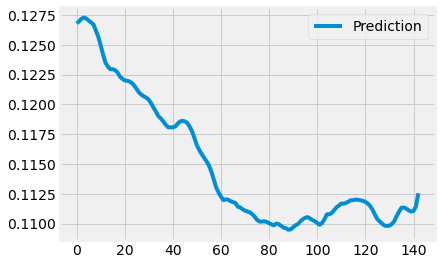

In [141]:
#Let's use the model and predict the stock
predicted_stock_price = model.predict(feature_train)
predicted_test = model.predict(feature_test)

# print(feature_test[-1::])
# print(predicted_stock_price)
plot_results(predicted_stock_price,label_train)
plot_results(predicted_test,label_test)

plot_result(predicted_stock_price)


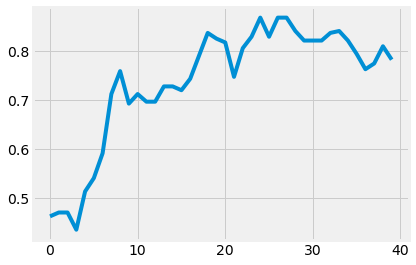

In [39]:
predictions = predict_sequences_multiple(model, feature_test, Enrol_window, 60)
plot_results_multiple(predictions, label_test, 100)  